In [ ]:
import json
import os
import math
import librosa
DATASET_PATH = "/content/drive/MyDrive/dataset/Data/genres_original"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
                        print("{}, segment:{}".format(file_path, d + 1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: pop
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:1
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:2
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:3
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:4
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:5
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:6
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:7
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:8
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:9
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00003.wav, segment:10
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00004.wav, segment:1
/content/drive/MyDrive/dataset/Data/genres_original/pop/pop.00004.wav, segment:2
/content/d

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import random

import librosa
import math

In [ ]:
# path to json
DATA_PATH ="/content/drive/MyDrive/dataset/Data/genres_original/data_10.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
# load data
X, y = load_data(DATA_PATH)

Data succesfully loaded!


# New Section

In [ ]:
X.shape

(999, 130, 13)

In [ ]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



```
# This is formatted as code
```

**SIMPLE** **ANN**

In [ ]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               865792    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
22/22 [==============================] - 1s 20ms/step - loss: 46.1699 - accuracy: 0.1416 - val_loss: 9.6602 - val_accuracy: 0.2600
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 6.5050 - accuracy: 0.3824 - val_loss: 4.8782 - val_accuracy: 0.4633
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 2.8564 - accuracy: 0.6075 - val_loss: 4.2969 - val_accuracy: 0.4967
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 1.9401 - accuracy: 0.6587 - val_loss: 3.8190 - val_accuracy: 0.5433
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 1.2012 - accuracy: 0.7794 - val_loss: 3.6575 - val_accuracy: 0.5467
Epoch 6/50
22/22 [==============================] - 0s 13ms/step - loss: 0.7202 - accuracy: 0.8602 - val_loss: 3.3520 - val_accuracy: 0.5467
Epoch 7/50
22/22 [==============================] - 0s 13ms/step - loss: 0.5491 - accuracy: 0.8836 - val_loss: 3.3495 - val_accuracy: 0.5667
Epoch 8/50
2

In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

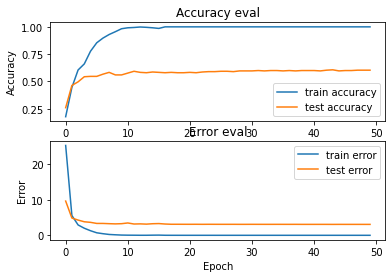

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history)

MANAGING OVERFITTING

In [ ]:
# build network topology
model_regularized = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_regularized.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# train model
history = model_regularized.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
22/22 [==============================] - 1s 26ms/step - loss: 86.8858 - accuracy: 0.1213 - val_loss: 16.0829 - val_accuracy: 0.2433
Epoch 2/100
22/22 [==============================] - 0s 17ms/step - loss: 37.0417 - accuracy: 0.1664 - val_loss: 7.0465 - val_accuracy: 0.3167
Epoch 3/100
22/22 [==============================] - 0s 16ms/step - loss: 23.9131 - accuracy: 0.1560 - val_loss: 6.1889 - val_accuracy: 0.3067
Epoch 4/100
22/22 [==============================] - 0s 16ms/step - loss: 19.0403 - accuracy: 0.2199 - val_loss: 4.3434 - val_accuracy: 0.3867
Epoch 5/100
22/22 [==============================] - 0s 16ms/step - loss: 15.5689 - accuracy: 0.2573 - val_loss: 4.2291 - val_accuracy: 0.3800
Epoch 6/100
22/22 [==============================] - 0s 16ms/step - loss: 14.1228 - accuracy: 0.2390 - val_loss: 3.9625 - val_accuracy: 0.3833
Epoch 7/100
22/22 [==============================] - 0s 17ms/step - loss: 11.7991 - accuracy: 0.2284 - val_loss: 3.6175 - val_accuracy: 0.403

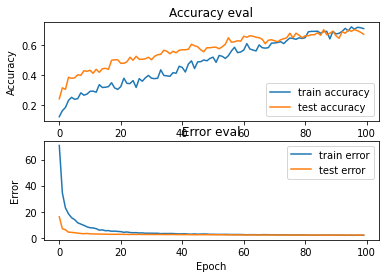

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history)



> Indented block


**Convolutional** **Neural** **Network**

In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
X_train.shape

(599, 130, 13, 1)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
# build the CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)        

In [ ]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
19/19 [==============================] - 2s 72ms/step - loss: 3.0798 - accuracy: 0.1441 - val_loss: 3.0291 - val_accuracy: 0.1733
Epoch 2/50
19/19 [==============================] - 1s 59ms/step - loss: 2.7089 - accuracy: 0.1957 - val_loss: 2.3480 - val_accuracy: 0.2267
Epoch 3/50
19/19 [==============================] - 1s 59ms/step - loss: 2.3291 - accuracy: 0.2687 - val_loss: 2.1139 - val_accuracy: 0.2667
Epoch 4/50
19/19 [==============================] - 1s 59ms/step - loss: 2.1442 - accuracy: 0.3216 - val_loss: 1.9458 - val_accuracy: 0.3000
Epoch 5/50
19/19 [==============================] - 1s 59ms/step - loss: 1.7712 - accuracy: 0.3722 - val_loss: 1.8080 - val_accuracy: 0.3267
Epoch 6/50
19/19 [==============================] - 1s 59ms/step - loss: 1.6887 - accuracy: 0.4314 - val_loss: 1.6413 - val_accuracy: 0.4267
Epoch 7/50
19/19 [==============================] - 1s 58ms/step - loss: 1.6312 - accuracy: 0.4620 - val_loss: 1.4967 - val_accuracy: 0.5333
Epoch 8/50
19

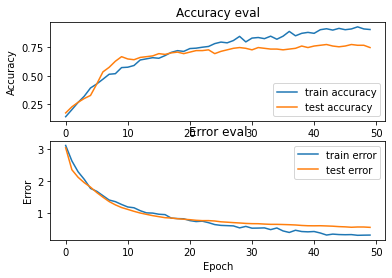

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [ ]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

8/8 - 0s - loss: 0.7059 - accuracy: 0.7560

Test accuracy: 0.7559999823570251


In [ ]:
model_cnn.save("Music_Genre_10_CNN")

INFO:tensorflow:Assets written to: Music_Genre_10_CNN/assets


In [ ]:
model_cnn.save("Music_Genre_10_CNN.h5")

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("Music_Genre_10_CNN.h5")

**Prediction** **on** **Test** **Set**

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [ ]:
X_to_predict.shape

(130, 13, 1)

In [ ]:
print("Real Genre:", y_to_predict)

Real Genre: 8


In [ ]:
# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
# perform prediction
prediction = model_cnn.predict(X_to_predict)

In [ ]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Predicted Genre: 8


In [ ]:

# pick a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 7
Predicted Genre: 2


In [ ]:
len(X_test)


250

In [ ]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_cnn.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: 3
Predicted Genre: 3

Real Genre: 5
Predicted Genre: 5

Real Genre: 9
Predicted Genre: 9

Real Genre: 0
Predicted Genre: 0

Real Genre: 4
Predicted Genre: 4

Real Genre: 3
Predicted Genre: 3

Real Genre: 0
Predicted Genre: 5

Real Genre: 8
Predicted Genre: 8

Real Genre: 9
Predicted Genre: 9

Real Genre: 3
Predicted Genre: 3


Prediction on New Songs

In [ ]:
# Audio files pre-processing
def process_input(audio_file, track_duration):

  SAMPLE_RATE = 22050
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
  
  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    return mfcc

In [ ]:
genre_dict = {0:"hiphop",1:"country",2:"jazz",3:"classical",4:"metal",5:"pop",6:"rock",7:"blues",8:"reggae",9:"disco"}

In [ ]:
new_input_mfcc = process_input("/content/drive/MyDrive/dataset/Data/genres_original/pop/blues.00001.wav", 30)

In [ ]:
type(new_input_mfcc)

numpy.ndarray

In [ ]:
new_input_mfcc.shape

(130, 13)

In [ ]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

Predicted Genre: blues


In [ ]:
new_input_mfcc = process_input("/content/drive/MyDrive/dataset/Data/genres_original/metal/metal.00004.wav", 30)

In [ ]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

Predicted Genre: rock
